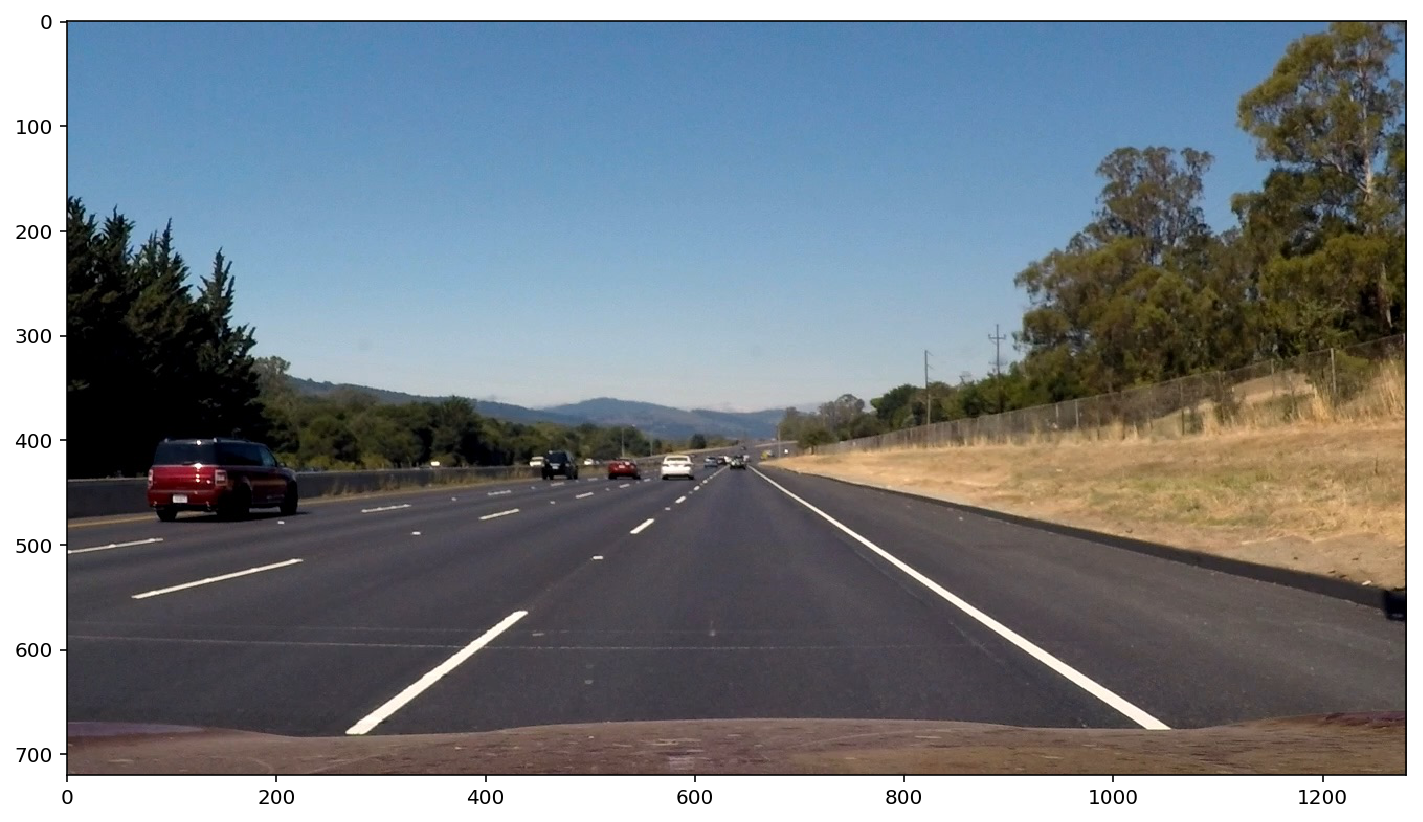

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def component():
  return random.randint(0,255)

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=2):
    # make a copy of the image
    draw_img = np.copy(img)
    
    for bbox in bboxes:
        (x1, y1), (x2, y2) = bbox
        cv2.rectangle(draw_img, (x1, y1), (x2, y2), (component(),component(),component()), thick)
    
    
    # draw each bounding box on your image copy using cv2.rectangle()
    # return the image copy with boxes drawn
    return draw_img # Change this line to return image copy with boxes

image = mpimg.imread('test_images/straight_lines2.jpg')

plt.figure(figsize=(12,12))
plt.imshow(image)

In [28]:
from skimage.feature import hog

def convert_color(img,cspace='RGB'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    
    return feature_image

def get_hog_features(
        img,
        cspace = 'RGB',
        orientations = 9, 
        pix_per_cell = 8, 
        cell_per_block = 2):
    
    
    img = convert_color(img,cspace)
    
    results = []
    
    for channel in range(img.shape[2]):
        
        image = img[:,:,channel]
 
        features = hog(
            image, 
            orientations=orientations,
            pixels_per_cell=(pix_per_cell, pix_per_cell), 
            cells_per_block=(cell_per_block, cell_per_block), 
            visualise=False, 
            feature_vector=False,
            block_norm="L2-Hys",
            transform_sqrt = False)
        
        results.append(features)
    
    result = np.array(results)
    
    return result


def get_spatial_features(img, size=(32, 32)):
 
    features = cv2.resize(img, size).ravel() 

    return features

 
def get_color_histogram_features(img, nbins=32, bins_range=(0, 256)):
  
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))

    return features


In [186]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import glob

def extract_features(files,get_features):
    
    features = []
        
    for file in files:
        
        image = mpimg.imread(file)
        
        features.append(get_features(image))
        
    return np.array(features)


def get_training_files(trainingset='smallset'):
    
    images = glob.glob('data/*{0}/*/*.*'.format(trainingset))
    
    cars = []
    notcars = []

    for image in images:
        if 'non-vehicles' in image:
            notcars.append(image)
        else:
            cars.append(image)
            
    return cars, notcars

 
    
def train(
        cspace = 'RGB',
        orientations = 9,
        pix_per_cell = 8,
        cell_per_block = 2):
    
    
    def get_features(image,hog_features = None):
        
        if hog_features == None:
        
            hog_features = get_hog_features(
                image,
                cspace = cspace,
                orientations = orientations,
                pix_per_cell = pix_per_cell,
                cell_per_block = cell_per_block)
            
        return np.ravel(hog_features).astype(np.float64)
            
         
    cars, notcars = get_training_files(trainingset='largeset')
      
    car_features = extract_features(
                            cars,
                            get_features)
    
    notcar_features = extract_features(
                            notcars,
                            get_features)
    
    y = np.hstack((np.ones(len(car_features)),np.zeros(len(notcar_features))))

    X = np.vstack((car_features, notcar_features)).astype(np.float64)
        
    X_scaler = StandardScaler().fit(X)

    scaled_X = X_scaler.transform(X)

    rand_state = np.random.randint(0, 100)
    
    
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, 
        y, 
        test_size=0.2, 
        random_state=rand_state)

    svc = LinearSVC()

    svc.fit(X_train, y_train) 
    
    print('Test Accuracy of SVC = ', svc.score(X_test, y_test))
    
    def predict(image,hog_features=None):
    
        features = get_features(image,hog_features)

        scaled = X_scaler.transform(features.reshape(1,-1))
    
        return svc.predict(scaled)
    
    return predict
  
predict = train(cspace = 'LUV')


Test Accuracy of SVC =  0.952702702703
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]


In [242]:
print(predict(mpimg.imread(notcars[np.random.randint(0, len(notcars))])))    


[ 1.]


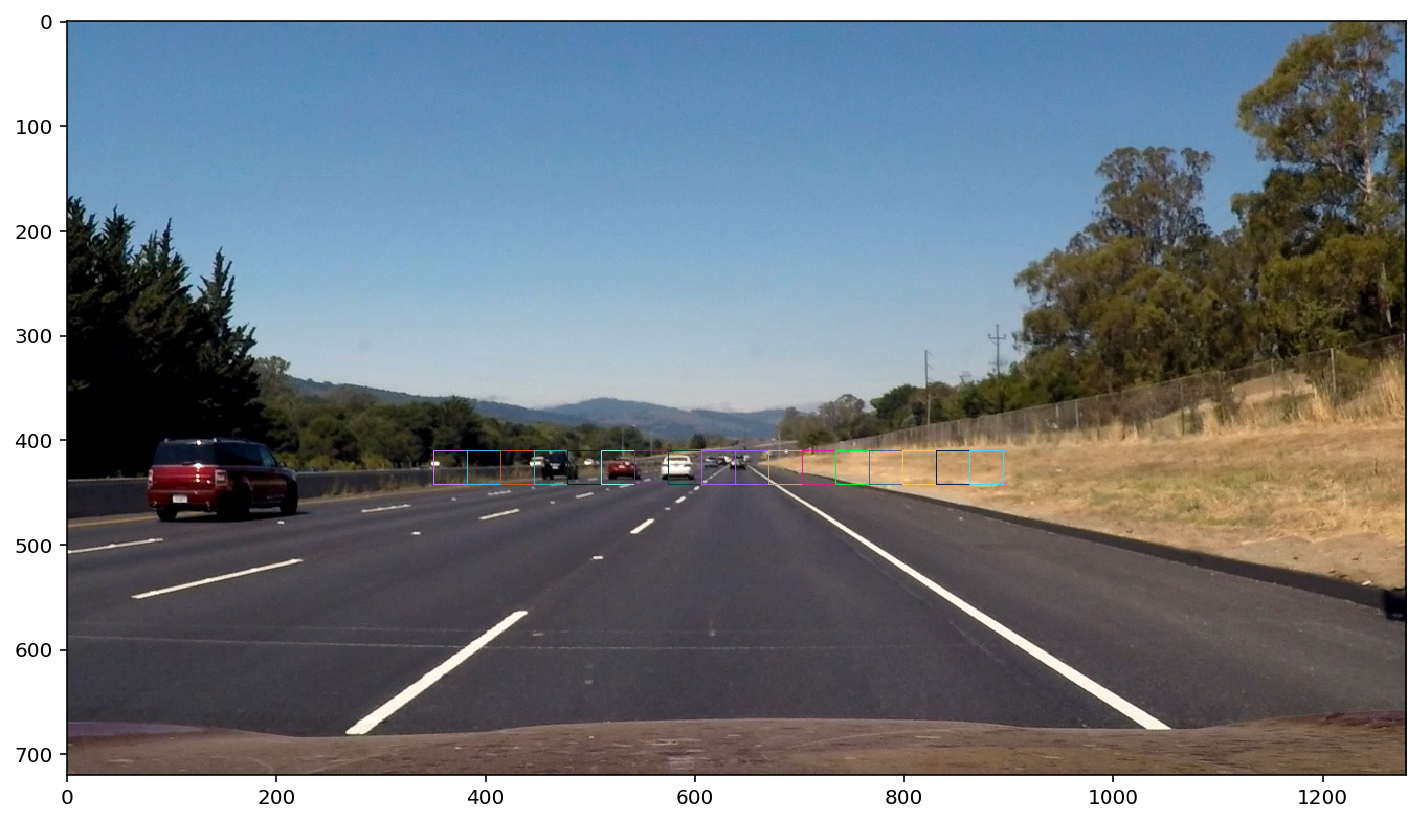

In [99]:
def convert_scale(image,scale):
    height,width = np.int(image.shape[0]/scale), np.int(image.shape[1]/scale)
    image = cv2.resize(image,(width,height))
    return image

def hog_sliding_windows(
        img,
        x_range,
        y_range,
        scale,
        cspace = 'RGB',
        cell_per_step = (2,2),
        orientations = 9,
        pix_per_cell = 8,
        cell_per_block = 2,
        block_per_window = 4):
        
    window = block_per_window * cell_per_block * pix_per_cell
    
    cell_per_step_x, cell_per_step_y = cell_per_step
    
    x_start,x_stop = x_range
    y_start,y_stop = y_range
    
    image = np.copy(img)
    image = img[y_start:y_stop,x_start:x_stop,:]
    image = convert_scale(image,scale)
    
    height,width,_ = image.shape
    
    hog_features = get_hog_features(
        image,
        cspace,
        orientations, 
        pix_per_cell, 
        cell_per_block)
    

    nxblocks = (width // pix_per_cell) - cell_per_block + 1
    nyblocks = (height // pix_per_cell) - cell_per_block + 1 
    
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1

    
    nxsteps = (nxblocks - nblocks_per_window + 1) // cell_per_step_x
    nysteps = (nyblocks - nblocks_per_window + 1) // cell_per_step_y
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            
            ypos = yb * cell_per_step_y
            xpos = xb * cell_per_step_x
        
            features = hog_features[:,ypos : ypos+nblocks_per_window,xpos : xpos+nblocks_per_window]
            #features = np.ravel(features)
        
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            #should not need to resize
            subimg = image[ytop:ytop+window, xleft:xleft+window]
            #subimg = cv2.resize(image[ytop:ytop+window, xleft:xleft+window], (64,64))
            
     
            xbox_left = np.int(xleft * scale) + x_start
            ybox_top = np.int(ytop * scale) + y_start
            box_width = np.int(window * scale)
            
    
            box_coordinates = ((xbox_left, ybox_top),(xbox_left + box_width, ybox_top + box_width))

            yield box_coordinates, features, subimg
    
image = mpimg.imread('test_images/straight_lines2.jpg')

y_center = 445
x_center = 640
y_width = 70
x_width = 580

windows = hog_sliding_windows(image,(350,930),(410,480),0.5,cell_per_step=(8,8))



bboxes = [box for box, _, _ in windows]


result = draw_boxes(image, bboxes, thick=1)
plt.figure(figsize=(12,12))
plt.imshow(result)
            
          
    
    
    
    
    
    
    
